Train C-index: 0.888
Train IBS: 0.326 (using 1400 time points)

Test C-index: 0.740
Test IBS: 0.334 (using 1400 time points)


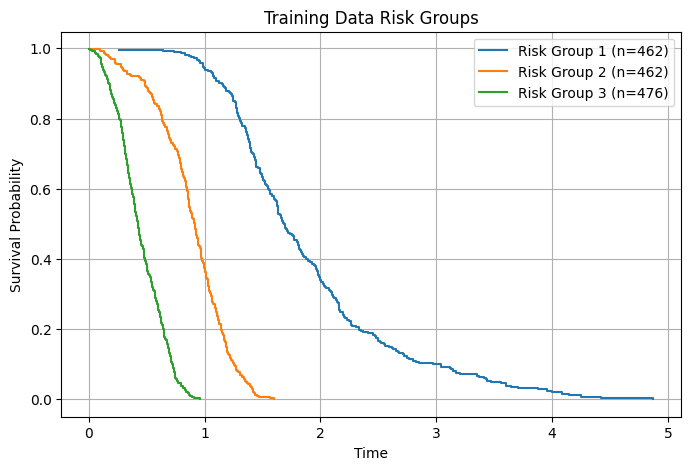

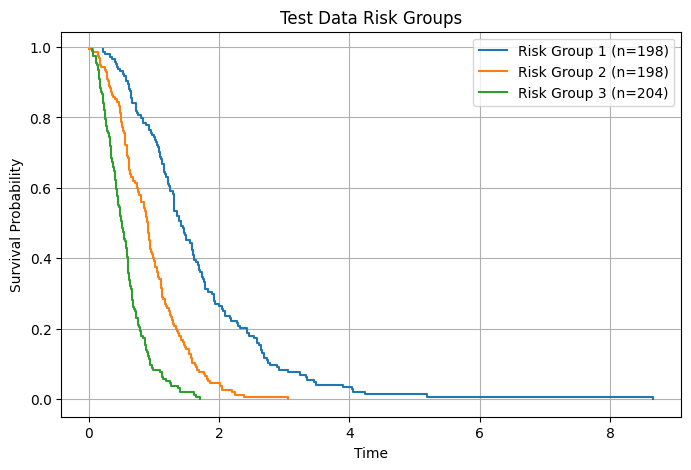

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored, integrated_brier_score
from sksurv.util import Surv
import matplotlib.pyplot as plt

# 1. Generate synthetic survival data
def generate_survival_data(n_samples=1000, n_features=10, random_state=None):
    np.random.seed(random_state)
    X = np.random.standard_normal((n_samples, n_features))
    
    # Create realistic survival times (Weibull distribution)
    scale = np.exp(0.5 * X[:, 0] + 0.1 * X[:, 1])
    shape = 2.0
    true_times = scale * np.random.weibull(shape, size=n_samples)
    
    # Add censoring (30% censored)
    censored = np.random.binomial(1, 0.7, size=n_samples)
    obs_times = np.where(censored, true_times, true_times * 0.7)
    
    return X, Surv.from_arrays(event=censored.astype(bool), time=obs_times)

# Generate and split data
X, y = generate_survival_data(n_samples=2000, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. Train model
rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf.fit(X_train, y_train)

# 3. Correct evaluation function
def evaluate_survival_model(model, X, y, y_train=None):
    if y_train is None:
        y_train = y
    
    # Get unique event times from training data
    train_event_times = np.unique(y_train['time'][y_train['event']])
    
    # Predict survival probabilities
    surv_funcs = model.predict_survival_function(X, return_array=True)
    
    # Calculate C-index
    pred = model.predict(X)
    c_index = concordance_index_censored(y['event'], y['time'], pred)[0]
    
    # Calculate IBS with proper time bounds
    max_time = y['time'].max() * 0.99  # Stay slightly below maximum observed time
    time_points = np.linspace(
        y['time'].min(),
        max_time,
        num=surv_funcs.shape[1]  # Match number of columns in survival estimates
    )
    
    try:
        ibs = integrated_brier_score(y_train, y, surv_funcs, time_points)
    except ValueError as e:
        print(f"Warning: {str(e)} - Adjusting time points")
        # If still failing, use the training event times that fall within test range
        valid_times = train_event_times[(train_event_times >= y['time'].min()) & 
                                      (train_event_times <= max_time)]
        time_points = np.linspace(
            y['time'].min(),
            max_time,
            num=len(valid_times)
        )
        ibs = integrated_brier_score(y_train, y, surv_funcs[:, :len(valid_times)], time_points)
    
    return {
        'c_index': c_index,
        'ibs': ibs,
        'n_time_points': len(time_points)
    }

# 4. Evaluate performance
metrics_train = evaluate_survival_model(rsf, X_train, y_train)
metrics_test = evaluate_survival_model(rsf, X_test, y_test, y_train)

print(f"Train C-index: {metrics_train['c_index']:.3f}")
print(f"Train IBS: {metrics_train['ibs']:.3f} (using {metrics_train['n_time_points']} time points)")
print(f"\nTest C-index: {metrics_test['c_index']:.3f}")
print(f"Test IBS: {metrics_test['ibs']:.3f} (using {metrics_test['n_time_points']} time points)")

# 5. Visualize survival curves
def plot_risk_groups(model, X, y, title):
    pred_risk = model.predict(X)
    groups = np.digitize(pred_risk, bins=np.quantile(pred_risk, [0.33, 0.66]))
    
    plt.figure(figsize=(8,5))
    for g in range(3):
        mask = groups == g
        time = y['time'][mask]
        event = y['event'][mask]
        # Simple KM estimator
        sorted_times = np.sort(time[event])
        surv_prob = 1 - np.arange(1, len(sorted_times)+1)/len(sorted_times)
        plt.step(sorted_times, surv_prob, where="post", 
                label=f'Risk Group {g+1} (n={sum(mask)})')
    
    plt.xlabel("Time")
    plt.ylabel("Survival Probability")
    plt.title(title)
    plt.legend()
    plt.grid()

plot_risk_groups(rsf, X_train, y_train, "Training Data Risk Groups")
plot_risk_groups(rsf, X_test, y_test, "Test Data Risk Groups")
plt.show()